In [1]:
import os
import sys
import torch
import pandas as pd
from tqdm.notebook import tqdm
import pickle as pk
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import DataLoader

device = torch.cuda.set_device(0)

BASE_DIR = ".."
MODEL_BASE_DIR = f"{BASE_DIR}/best_models"
DATA_DIR = f"{BASE_DIR}/nbdata"
os.makedirs(MODEL_BASE_DIR,exist_ok=True)
os.makedirs(DATA_DIR,exist_ok=True)
sys.path.append(BASE_DIR)

from plm_dti import DTIDataset, molecule_protein_collate_fn

In [2]:
from tdc import utils
from tdc.benchmark_group import dti_dg_group

names = utils.retrieve_benchmark_names('DTI_DG_Group')
group = dti_dg_group(path = DATA_DIR)
benchmark = group.get('bindingdb_patent')
name = benchmark['name']
train_val, test = benchmark['train_val'], benchmark['test'] ## Natural log transformed (kd/ki/ic50??)

Found local copy...


In [37]:
test

,Drug_ID,Drug,Target_ID,Target,Y,Year
0,126484387.0,CC(=O)Nc1cc(Nc2nc(nn3ccc(CNCC(C)(C)O)c23)-c2cc...,P37173,MGRGLLRGLWPLHIVLWTRIASTIPPHVQKSVNNDMIVTDNNGAVK...,9.615805,2019
1,126484452.0,OCCN1CCN(Cc2ccn3nc(nc(Nc4ccncc4F)c23)-c2cccc(n...,P37173,MGRGLLRGLWPLHIVLWTRIASTIPPHVQKSVNNDMIVTDNNGAVK...,9.615805,2019
2,126484204.0,O[C@H]1CCN(Cc2ccn3nc(nc(Nc4ccncc4F)c23)-c2cccc...,P37173,MGRGLLRGLWPLHIVLWTRIASTIPPHVQKSVNNDMIVTDNNGAVK...,6.522093,2019
3,126484351.0,CC(=O)Nc1cc(Nc2nc(nn3ccc(CN4CCN(CCO)CC4)c23)-c...,P37173,MGRGLLRGLWPLHIVLWTRIASTIPPHVQKSVNNDMIVTDNNGAVK...,7.170120,2019
4,126484298.0,COc1nc(cs1)-c1nc(Nc2ccncc2F)c2cccn2n1,P37173,MGRGLLRGLWPLHIVLWTRIASTIPPHVQKSVNNDMIVTDNNGAVK...,9.615805,2019
...,...,...,...,...,...,...
49023,122670107.0,COc1cc(cnc1C(=O)C1CC1C(=O)NS(=O)(=O)c1ccccc1F)...,Q16873,MKDEVALLAAVTLLGVLLQAYFSLQVISARRAFRVSPPLTTGPPEF...,4.304065,2021
49024,122679444.0,COc1cc(ncc1C(=O)C1CC1C(O)=O)N(CC1CC1)c1ccc(C)c...,Q16873,MKDEVALLAAVTLLGVLLQAYFSLQVISARRAFRVSPPLTTGPPEF...,4.025352,2021
49025,122670055.0,COc1cc(ccc1C(=O)C1CC1C(O)=O)N(CC1CC1)c1ccc(C)c...,Q16873,MKDEVALLAAVTLLGVLLQAYFSLQVISARRAFRVSPPLTTGPPEF...,4.127134,2021
49026,122670085.0,COc1cc(ccc1C(=O)C1CC1C(O)=O)N(CC1CC1)c1ccc(Cl)...,Q16873,MKDEVALLAAVTLLGVLLQAYFSLQVISARRAFRVSPPLTTGPPEF...,4.110874,2021


In [36]:
train_val

,Drug_ID,Drug,Target_ID,Target,Y,Year
0,91808352.0,COCc1ccccc1C1C(C(=O)C(C)C)C(=O)C(=O)N1c1ccc(cc...,P56373,MNCISDFFTYETTKSVVVKSWTIGIINRVVQLLIISYFVGWVFLHE...,2.564949,2013
1,67223437.0,Cc1c2[C@@H]3CCCN([C@@H]3Cc2ccc1C#N)C(=O)c1ccc2...,P28845,MAFMKKYLLPILGLFMAYYYYSANEEFRPEMLQGKKVIVTGASKGI...,4.605170,2013
2,46222354.0,CC(C)(C#N)c1cccc(C(=O)Nc2cccc(Oc3ccc4nc(NC(=O)...,Q02750,MPKKKPTPIQLNPAPDGSAVNGTSSAETNLEALQKKLEELELDEQQ...,5.703782,2013
3,59454472.0,CC(=O)Nc1nc2ccc(Oc3cccc(NC(=O)Nc4ccc(cc4)C(C)(...,Q02750,MPKKKPTPIQLNPAPDGSAVNGTSSAETNLEALQKKLEELELDEQQ...,5.703782,2013
4,46222580.0,Fc1ccc(Oc2ccc3nc(NC(=O)C4CC4)sc3c2C#N)cc1NC(=O...,Q02750,MPKKKPTPIQLNPAPDGSAVNGTSSAETNLEALQKKLEELELDEQQ...,5.703782,2013
...,...,...,...,...,...,...
183425,145995481.0,Clc1ccc(cc1)-n1cc(cn1)C(=O)Nc1ccc(cc1)-c1n[nH]...,O75116,MSRPPPTGKMPGAPETAPGDGAGASRQRKLEALIRDPRSPINVESL...,4.605170,2018
183426,145995482.0,O=C(Nc1ccc(cc1)-c1n[nH]c(=O)c2ccccc12)c1cnn(c1...,Q13464,MSTGDSFETRFEKMDNLLRDPKSEVNSDCLLDGLDALVYDLDFPAL...,6.309918,2018
183427,145995482.0,O=C(Nc1ccc(cc1)-c1n[nH]c(=O)c2ccccc12)c1cnn(c1...,O75116,MSRPPPTGKMPGAPETAPGDGAGASRQRKLEALIRDPRSPINVESL...,4.605170,2018
183428,145995485.0,O=C(Nc1ccc(cc1)-c1n[nH]c(=O)c2ccccc12)c1cnn(c1...,Q13464,MSTGDSFETRFEKMDNLLRDPKSEVNSDCLLDGLDALVYDLDFPAL...,4.605170,2018


In [30]:
train_val.iloc[5]

Drug_ID                                             59454502.0
Drug         CC(=O)Nc1nc2ccc(Oc3cccc(NC(=O)Cc4cccc(c4)C(F)(...
Target_ID                                               Q02750
Target       MPKKKPTPIQLNPAPDGSAVNGTSSAETNLEALQKKLEELELDEQQ...
Y                                                     5.703782
Year                                                      2013
Name: 5, dtype: object

In [29]:
train_val.iloc[5].Drug

'CC(=O)Nc1nc2ccc(Oc3cccc(NC(=O)Cc4cccc(c4)C(F)(F)F)c3)c(C#N)c2s1'

In [3]:
all_drugs = pd.concat([train_val,test]).Drug.values
all_proteins = pd.concat([train_val,test]).Target.values

In [4]:
from mol_feats import Morgan_f, Morgan_DC_f
from prot_feats import Prose_f, ProtBert_f, ProtT5_XL_Uniref50_f

mol_featurizer = Morgan_DC_f()
prot_featurizer = ProtBert_f()

In [5]:
to_disk_path = f"{DATA_DIR}/tdc_bindingdb_patent_train"

mol_featurizer.precompute(all_drugs,to_disk_path=to_disk_path,from_disk=True)
prot_featurizer.precompute(all_proteins,to_disk_path=to_disk_path,from_disk=True)

--- precomputing morgan_DC molecule featurizer ---
--- loading from disk ---
--- precomputing ProtBert protein featurizer ---
--- loading from disk ---


In [30]:
## --- train your model --- ##

In [53]:
# class SimplePLMModel(nn.Module):
#     def __init__(self,
#                  mol_emb_size = 2048,
#                  prot_emb_size = 1024,
#                  hidden_dim = 512,
#                  activation = nn.ReLU
#                 ):
#         super().__init__()
#         self.mol_emb_size = mol_emb_size
#         self.prot_emb_size = prot_emb_size

#         self.mol_projector = nn.Sequential(
#             nn.Linear(self.mol_emb_size, hidden_dim),
#             activation()
#         )

#         self.prot_projector = nn.Sequential(
#             nn.Linear(self.prot_emb_size, hidden_dim),
#             activation()
#         )
        
#         self.fc = nn.Linear(2*hidden_dim, 1)

#     def forward(self, mol_emb, prot_emb):
#         # print(prot_emb.shape)
#         mol_proj = self.mol_projector(mol_emb)
#         prot_proj = self.prot_projector(prot_emb)
#         # print(mol_proj.shape, prot_proj.shape)
#         cat_emb = torch.cat([mol_proj, prot_proj],axis=1)
#         # print(cat_emb.shape)
#         return self.fc(cat_emb).squeeze()
    
# class LinearPLMModel(nn.Module):
#     def __init__(self,
#                  mol_emb_size = mol_featurizer._size,
#                  prot_emb_size = prot_featurizer._size,
#                 ):
#         super().__init__()
#         self.mol_emb_size = mol_emb_size
#         self.prot_emb_size = prot_emb_size
#         self.fc = nn.Linear(mol_emb_size + prot_emb_size, 1)

#     def forward(self, mol_emb, prot_emb):
#         cat_emb = torch.cat([mol_emb, prot_emb],axis=1)
#         return self.fc(cat_emb).squeeze()

In [7]:
import wandb
import copy
from torch.autograd import Variable
from time import time
from scipy.stats import pearsonr

test_dataset = DTIDataset(
        test.Drug,
        test.Target,
        test.Y,
        mol_featurizer,
        prot_featurizer,
    )

test_dataloader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=lambda x: molecule_protein_collate_fn(x, pad=False))

In [39]:
best_models = {}

for seed in range(5):
    train, valid = group.get_train_valid_split(benchmark = name, split_type = 'default', seed = seed)

    train_dataset = DTIDataset(
        train.Drug,
        train.Target,
        train.Y,
        mol_featurizer,
        prot_featurizer,
    )

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        collate_fn=lambda x: molecule_protein_collate_fn(x, pad=False))

    valid_dataset = DTIDataset(
        valid.Drug,
        valid.Target,
        valid.Y,
        mol_featurizer,
        prot_featurizer,
    )

    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=32,
        shuffle=True,
        collate_fn=lambda x: molecule_protein_collate_fn(x, pad=False))
    
    # wandb.init(
    #         project=args.wandb_proj,
    #         name=config.experiment_id,
    #         config=flatten(config),
    #     )
    # wandb.watch(model, log_freq=100)

    # early stopping
    max_pcc = 0

    model = SimplePLMModel().cuda()
    torch.backends.cudnn.benchmark = True
    n_epo = 10
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    every_n_val = 1
    loss_history = []

    tg_len = len(train_dataloader)
    start_time = time()
    for epo in tqdm(range(n_epo)):
        model.train()
        epoch_time_start = time()
        for i, (d, p, label) in enumerate(train_dataloader):

            score = model(d.cuda(), p.cuda())
            label = Variable(torch.from_numpy(np.array(label)).float()).cuda()

            loss_fct = torch.nn.MSELoss()

            loss = loss_fct(score, label)
            loss_history.append((epo, i, float(loss.cpu().detach().numpy())))
            # wandb.log({"train/loss": loss, "epoch": epo,
            #                "step": epo*tg_len*args.batch_size + i*args.batch_size
            #           })

            opt.zero_grad()
            loss.backward()
            opt.step()

            if (i % 1000 == 0):
                print(f'[{seed}] Training at Epoch {epo+1} iteration {i} with loss {loss.cpu().detach().numpy()}')

        epoch_time_end = time()
        if epo % 5 == 0:
            with torch.set_grad_enabled(False):
                pred_list = []
                lab_list = []
                model.eval()
                for i, (d, p, label) in enumerate(valid_dataloader):
                    score = model(d.cuda(), p.cuda())
                    score = score.detach().cpu().numpy()
                    label = label.detach().cpu().numpy()
                    pred_list.extend(score)
                    lab_list.extend(label)

                pred_list = torch.tensor(pred_list)
                lab_list = torch.tensor(lab_list)
                val_pcc = pearsonr(pred_list, lab_list)[0]
                # wandb.log({"val/loss": val_loss, "epoch": epo,
                #            "val/pcc": float(val_pcc),
                #            "Charts/epoch_time": (epoch_time_end - epoch_time_start)/config.training.every_n_val
                #   })
                if val_pcc > max_pcc:
                    model_max = copy.deepcopy(model)
                    max_pcc = val_pcc
                print(f'[{seed}] Validation at Epoch {epo+1}: PCC={val_pcc}')
        end_time = time()
        
    best_models[seed] = (model_max, max_pcc)
    torch.save(model_max, f"{MODEL_BASE_DIR}/TDC_DTI_DG_seed{seed}_best_model.sav")

generating training, validation splits...


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([32, 2, 1024])
torch.Size([32, 512]) torch.Size([32, 2, 512])


RuntimeError: Tensors must have same number of dimensions: got 3 and 2

In [12]:
pcc_seed = {}

for seed in range(5):
    pred_list = []

    best_mod_ev = best_models[seed][0]
    best_mod_ev.eval()
    with torch.no_grad():
        for i, (d, p, label) in enumerate(test_dataloader):
            score = best_mod_ev(d.cuda(), p.cuda())
            score = score.detach().cpu().numpy()
            pred_list.extend(score)

    pred_list = np.array(pred_list)
    predictions = {name: pred_list}
    
    out = group.evaluate(predictions)
    pcc_seed[seed] = out
    print(f'{seed}: PCC={out[name]["pcc"]}')
print(f'Average PCC: {sum([pcc_seed[s][name]["pcc"] for s in range(5)])/5}')

0: PCC=0.504
1: PCC=0.518
2: PCC=0.505
3: PCC=0.506
4: PCC=0.529
Average PCC: 0.5124000000000001


In [28]:
#####################

In [9]:
from architectures import AffinityConcatLinear as LinearPLMModel

In [10]:
mod = torch.load(f'{MODEL_BASE_DIR}/dti_dg_morganM_protbertP_linear_bm_best_model.sav').eval().cuda()

In [11]:
mod

AffinityConcatLinear(
  (fc): Linear(in_features=3072, out_features=1, bias=True)
)

In [12]:
mod_predictions = []
mod_labels = []

with torch.no_grad():
    for i, (d, p, label) in enumerate(test_dataloader):
        score = mod(d.cuda(), p.cuda())
        score = score.detach().cpu().numpy()
        mod_predictions.extend(score)
        mod_labels.extend(label)
mod_predictions = np.array(mod_predictions)
mod_labels = np.array(mod_labels)

In [15]:
from scipy.stats import pearsonr
sns.set(rc={'figure.figsize': (10,10)},style='whitegrid')

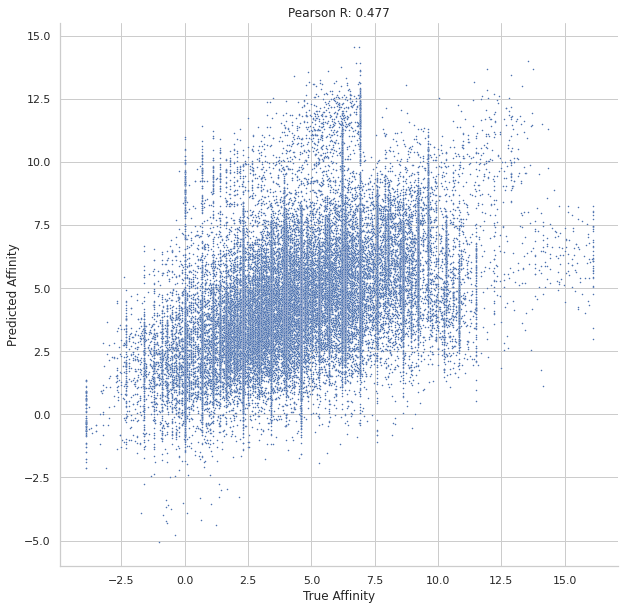

In [16]:
sns.scatterplot(x=mod_labels, y=mod_predictions,s=2.5)
plt.title(f'Pearson R: {pearsonr(mod_labels, mod_predictions)[0]:.3f}')
plt.xlabel('True Affinity')
plt.ylabel('Predicted Affinity')
sns.despine()
plt.show()

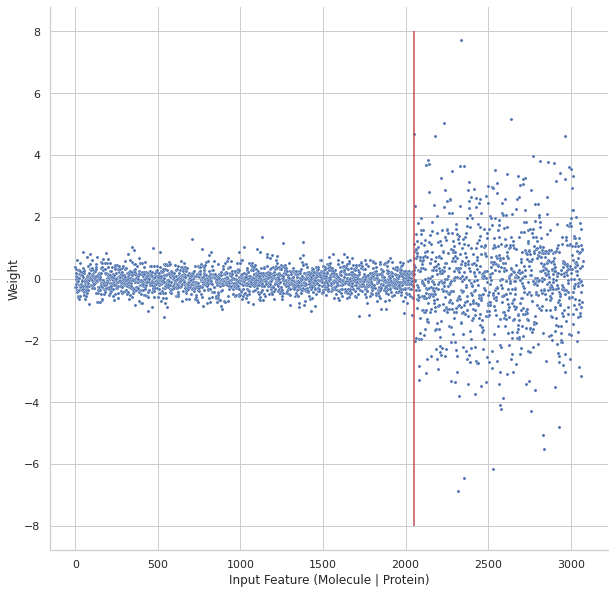

In [17]:
wghts = mod.fc._parameters['weight'].cpu().detach().squeeze().numpy()
sns.scatterplot(np.arange(len(wghts)),wghts,s=10)
plt.vlines(2048,-8,8,color='r')
plt.xlabel('Input Feature (Molecule | Protein)')
plt.ylabel('Weight')
sns.despine()
plt.show()